In [1]:
import keras
from keras import layers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from keras.datasets import mnist
import numpy as np

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

#normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 784)
(10000, 784)


### 1. Vanilla Encoder

Epoch 1/10


I0000 00:00:1726587039.775343     105 service.cc:145] XLA service 0x7cbd88007790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726587039.775399     105 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726587039.775404     105 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 71/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5446

I0000 00:00:1726587040.928947     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.3914 - val_loss: 0.1877
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1795 - val_loss: 0.1534
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1495 - val_loss: 0.1338
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1318 - val_loss: 0.1220
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1213 - val_loss: 0.1140
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1142 - val_loss: 0.1085
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1085 - val_loss: 0.1042
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1043 - val_loss: 0.1004
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1010 - val_loss: 0.0979
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0985 - val_loss: 0.0962
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0966

Summary: Loss over the test dataset: 0.10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


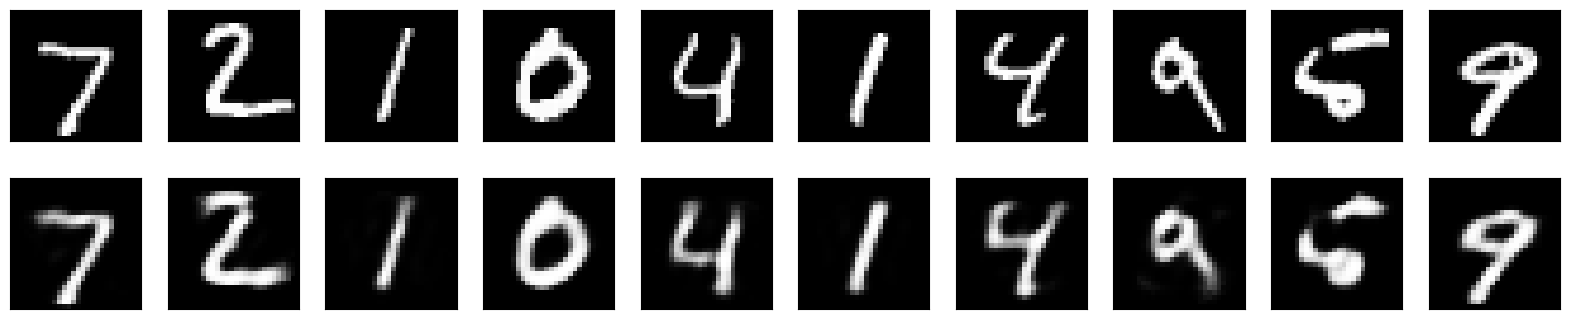

In [3]:
# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)
# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

#train our autoencoder for 50 epochs
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
evaluation = autoencoder.evaluate(x_test, x_test, batch_size=256, verbose=1)
print('\nSummary: Loss over the test dataset: %.2f' % (evaluation))
import matplotlib.pyplot as plt
# Decode test images
decoded_imgs = autoencoder.predict(x_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 2. Adding a sparsity constant

In [4]:
from keras import regularizers
nb_hidden = 1024
nb_visible = 784
nb_epoch = 10
batch_size = 256

# Build autoencoder model
input_img = keras.Input(shape=(nb_visible,))
encoded = Dense(nb_hidden, activation='relu', activity_regularizer=regularizers.l1(10e-7))(input_img)
decoded = Dense(nb_visible, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       803,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,607,440 (6.13 MB)

 Trainable params: 1,607,440 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2850 - val_loss: 0.1249
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1195 - val_loss: 0.1064
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1046 - val_loss: 0.0993
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0984 - val_loss: 0.0953
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0947 - val_loss: 0.0925
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0919 - val_loss: 0.0906
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0900 - val_loss: 0.0888
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0884 - val_loss: 0.0875
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0869 - val_loss: 0.0864
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0859 - val_loss: 0.0853
Training Finished!
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0849

Summary: Loss over the test dataset: 0.09
313/313 ━━━━━━━━━━━━━━━

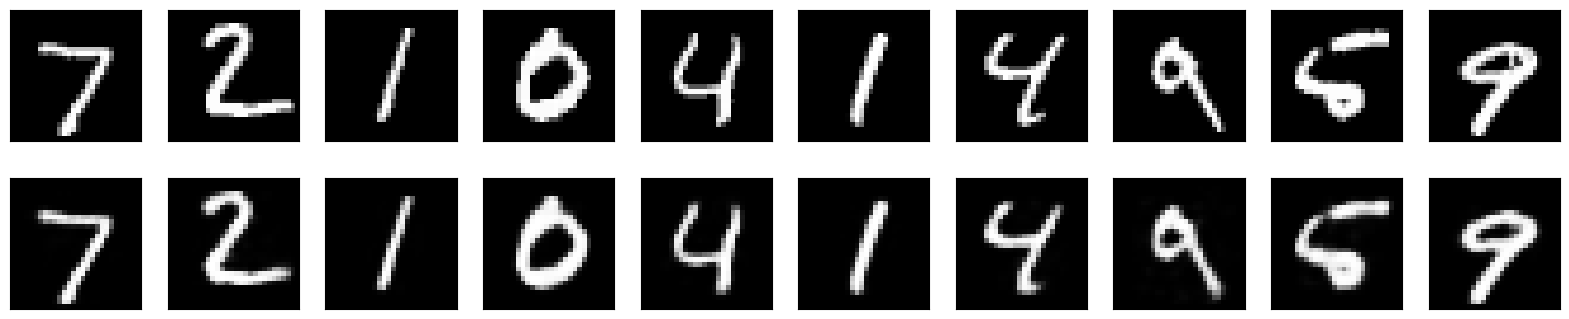

In [5]:
# Train
autoencoder.fit(x_train, x_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True, verbose=1,
                validation_data=(x_test, x_test))
print("Training Finished!")
# Evaluate
evaluation = autoencoder.evaluate(x_test, x_test, batch_size=batch_size, verbose=1)
print('\nSummary: Loss over the test dataset: %.2f' % (evaluation))
# Decode test images
decoded_imgs = autoencoder.predict(x_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Shape of Hidden Layer (784, 128)
Visualization of first 128 nodes in the Hidden Layer


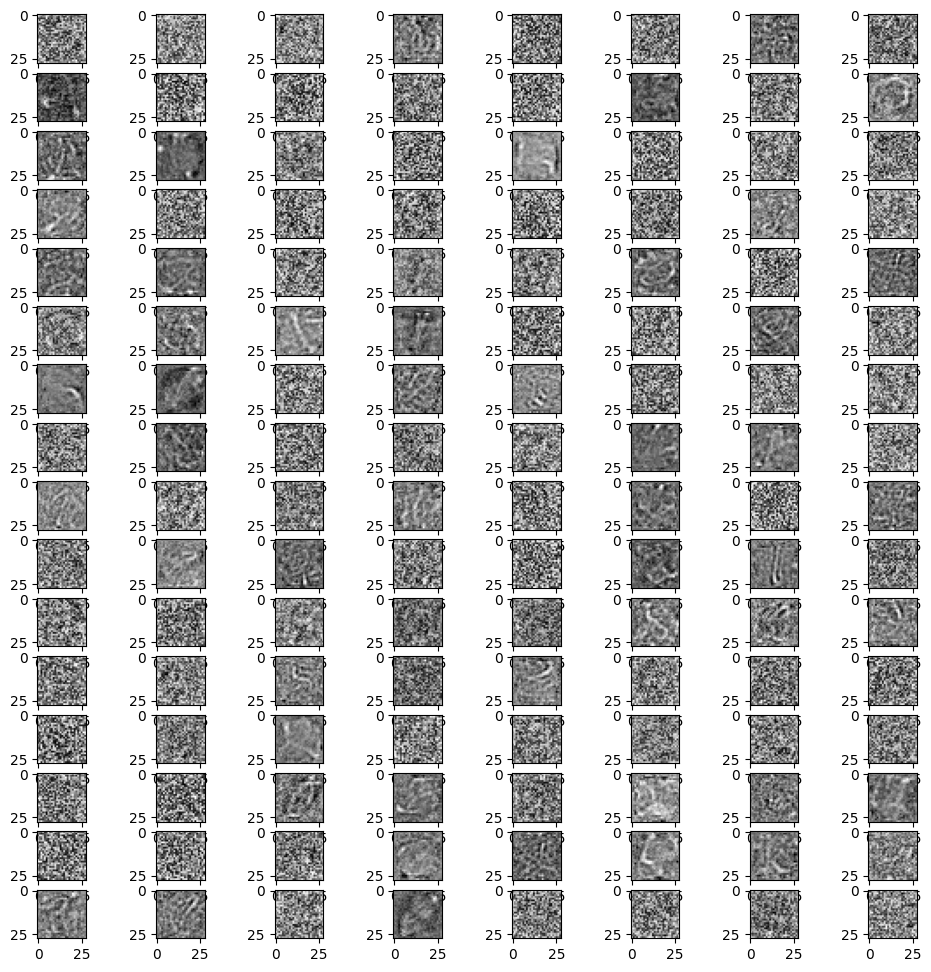

In [6]:
w = []
for layer in autoencoder.layers:
    weights = layer.get_weights()
    w.append(weights)

nb_show = 128
layer = np.array(w[1][0])
layer1 = layer[:,0:nb_show]
print("Shape of Hidden Layer",layer1.shape)
print("Visualization of first",nb_show,"nodes in the Hidden Layer")
fig=plt.figure(figsize=(12, 12))
columns = 8
rows = int(nb_show/8)
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(layer1[:,i-1].reshape(28,28),cmap='gray')
plt.show()


### 3. Deep Autoencoder

In [8]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)
decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
# Evaluate
evaluation = autoencoder.evaluate(x_test, x_test, batch_size=batch_size, verbose=1)
print('\nSummary: Loss over the test dataset: %.2f' % (evaluation))
# Decode test images
decoded_imgs = autoencoder.predict(x_test)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.3325 - val_loss: 0.1624
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1547 - val_loss: 0.1349
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1328 - val_loss: 0.1247
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1236 - val_loss: 0.1167
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1172 - val_loss: 0.1119
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1129 - val_loss: 0.1089
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1098 - val_loss: 0.1068
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1078 - val_loss: 0.1044
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1054 - val_loss: 0.1024
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1032 - val_loss: 0.1009
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1013 - val_loss: 0.0991
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

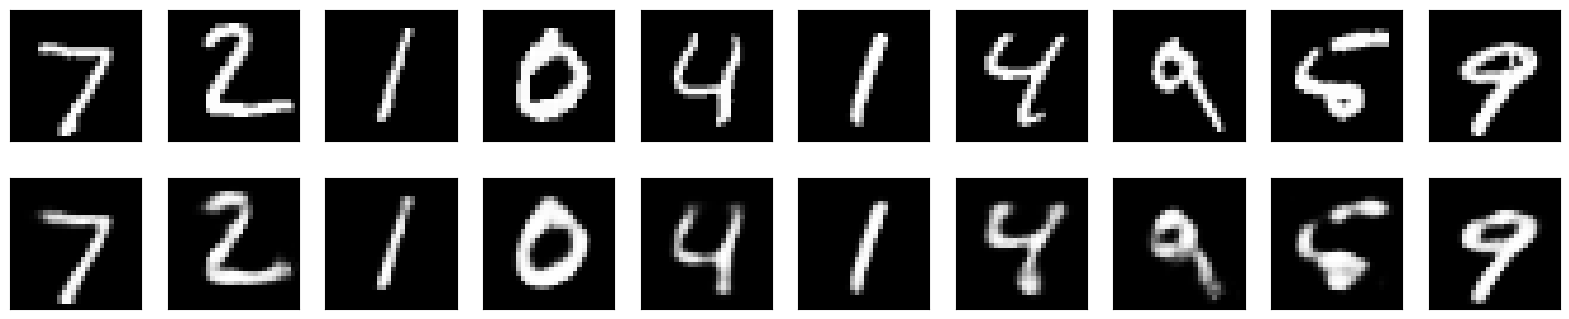

In [9]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


### 4. Denoising Autoencoder

In [10]:
# Add random noise
corruption_level = 0.3
x_train_noisy = x_train + corruption_level * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + corruption_level * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
print(x_train_noisy.shape)
print(x_test_noisy.shape)
# Hyper parameters
batch_size = 256
nb_epoch = 10
# Parameters for MNIST dataset
img_rows, img_cols = 28, 28
# Parameters for denoising autoencoder
nb_visible = img_rows * img_cols
nb_hidden = 32
# Build autoencoder model
input_img = Input(shape=(nb_visible,))
encoded = Dense(nb_hidden, activation='relu')(input_img)
decoded = Dense(nb_visible, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()


(60000, 784)
(10000, 784)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 784)            │        25,872 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,992 (199.19 KB)

 Trainable params: 50,992 (199.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3730 - val_loss: 0.2113
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1986 - val_loss: 0.1681
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1633 - val_loss: 0.1462
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1441 - val_loss: 0.1330
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1322 - val_loss: 0.1242
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1242 - val_loss: 0.1195
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1203 - val_loss: 0.1156
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1161 - val_loss: 0.1135
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1146 - val_loss: 0.1125
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1135 - val_loss: 0.1119
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1127

Summary: Loss over the test dataset: 0.11
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


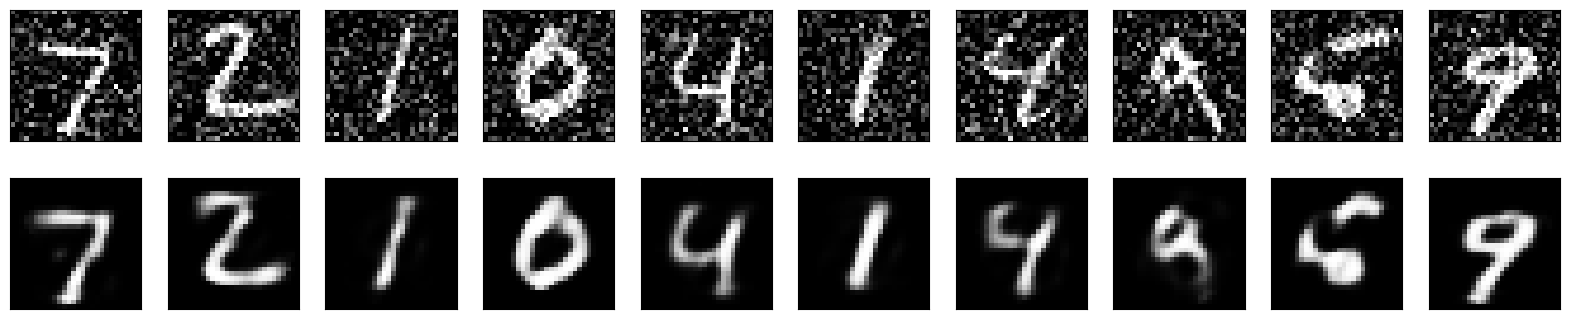

In [11]:
# Train
autoencoder.fit(x_train_noisy, x_train,
                epochs=nb_epoch, batch_size=batch_size, shuffle=True, verbose=1,
                validation_data=(x_test_noisy, x_test))
# Evaluate
evaluation = autoencoder.evaluate(x_test_noisy, x_test, batch_size=batch_size, verbose=1)
print('\nSummary: Loss over the test dataset: %.2f' % (evaluation))
import matplotlib.pyplot as plt
%matplotlib inline
# Decode test images
decoded_imgs = autoencoder.predict(x_test_noisy)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Shape of Hidden Layer (784, 32)
Visualization of Hidden Layer


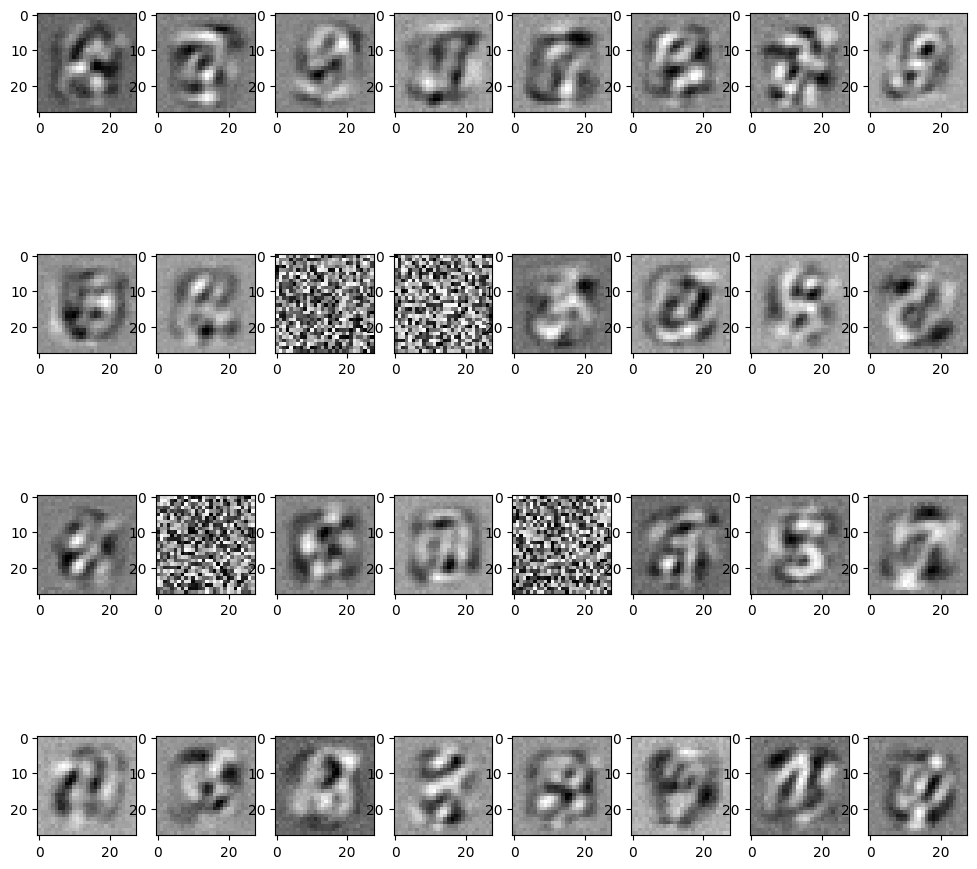

In [12]:
w = []
for layer in autoencoder.layers:
    weights = layer.get_weights()
    w.append(weights)
layer1 = np.array(w[1][0])
print("Shape of Hidden Layer",layer1.shape)
print("Visualization of Hidden Layer")
fig=plt.figure(figsize=(12, 12))
columns = 8
rows = int(nb_hidden/8)
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(layer1[:,i-1].reshape(28,28),cmap='gray')
plt.show()


## Exercise 1 - Adding more noise

In [13]:
# Add random noise
corruption_level = 0.5
x_train_noisy = x_train + corruption_level * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + corruption_level * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
print(x_train_noisy.shape)
print(x_test_noisy.shape)
# Hyper parameters
batch_size = 256
nb_epoch = 10
# Parameters for MNIST dataset
img_rows, img_cols = 28, 28
# Parameters for denoising autoencoder
nb_visible = img_rows * img_cols
nb_hidden = 32
# Build autoencoder model
input_img = Input(shape=(nb_visible,))
encoded = Dense(nb_hidden, activation='relu')(input_img)
decoded = Dense(nb_visible, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()


(60000, 784)
(10000, 784)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 784)            │        25,872 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,992 (199.19 KB)

 Trainable params: 50,992 (199.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3693 - val_loss: 0.2169
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2049 - val_loss: 0.1777
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1741 - val_loss: 0.1611
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1598 - val_loss: 0.1504
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1493 - val_loss: 0.1427
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1422 - val_loss: 0.1374
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1371 - val_loss: 0.1325
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1328 - val_loss: 0.1302
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1307 - val_loss: 0.1286
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1293 - val_loss: 0.1276
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1284

Summary: Loss over the test dataset: 0.13
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


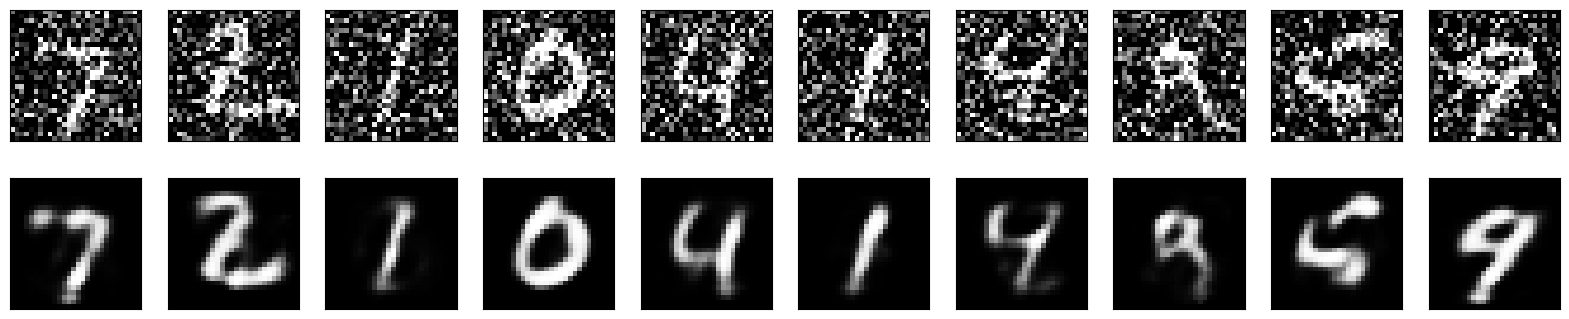

In [14]:
# Train
autoencoder.fit(x_train_noisy, x_train,
                epochs=nb_epoch, batch_size=batch_size, shuffle=True, verbose=1,
                validation_data=(x_test_noisy, x_test))
# Evaluate
evaluation = autoencoder.evaluate(x_test_noisy, x_test, batch_size=batch_size, verbose=1)
print('\nSummary: Loss over the test dataset: %.2f' % (evaluation))
import matplotlib.pyplot as plt
%matplotlib inline
# Decode test images
decoded_imgs = autoencoder.predict(x_test_noisy)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Shape of Hidden Layer (784, 32)
Visualization of Hidden Layer


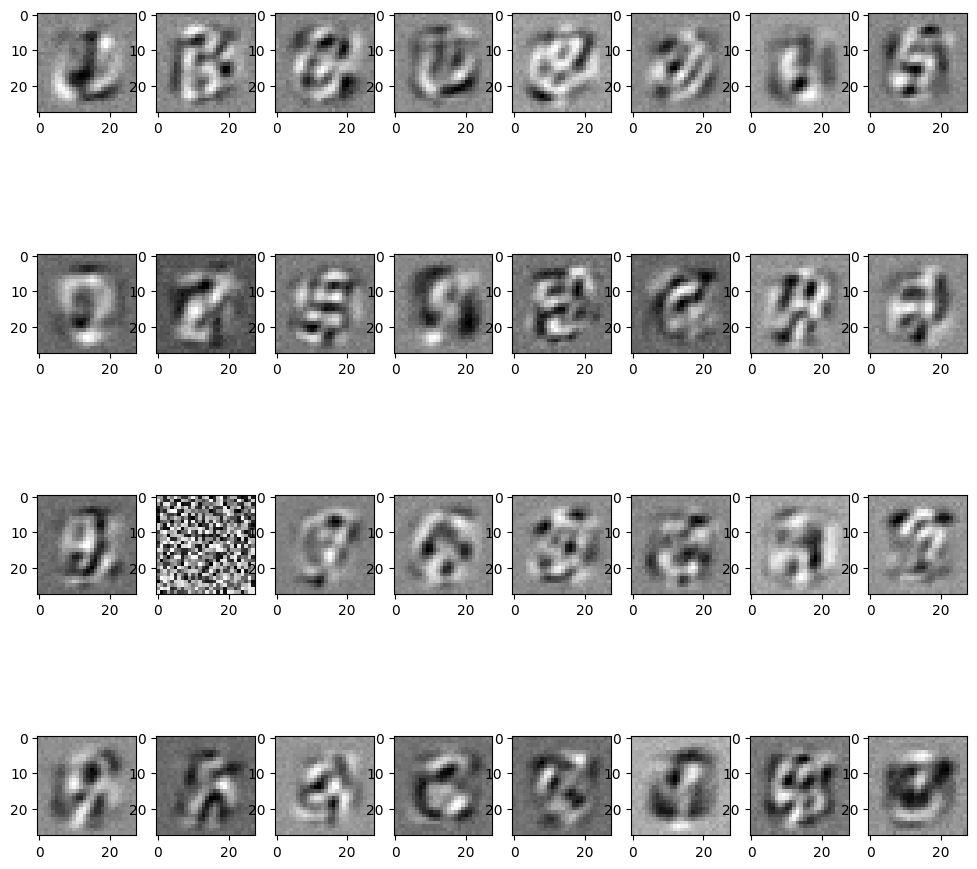

In [15]:
w = []
for layer in autoencoder.layers:
    weights = layer.get_weights()
    w.append(weights)
layer1 = np.array(w[1][0])
print("Shape of Hidden Layer",layer1.shape)
print("Visualization of Hidden Layer")
fig=plt.figure(figsize=(12, 12))
columns = 8
rows = int(nb_hidden/8)
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(layer1[:,i-1].reshape(28,28),cmap='gray')
plt.show()


### 5. Convolutional Autoencoders

In [16]:
import keras
from keras import layers
input_img = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
x_train_new = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test_new = np.reshape(x_test, (len(x_test), 28, 28, 1))
autoencoder.fit(x_train_new, x_train_new,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_new, x_test_new))
# Evaluate
evaluation = autoencoder.evaluate(x_test_new, x_test_new, batch_size=batch_size, verbose=1)
print('\nSummary: Loss over the test dataset: %.2f' % (evaluation))

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.3212 - val_loss: 0.1444
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1391 - val_loss: 0.1245
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1230 - val_loss: 0.1154
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1156 - val_loss: 0.1108
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1114 - val_loss: 0.1078
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1086 - val_loss: 0.1056
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1064 - val_loss: 0.1037
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1046 - val_loss: 0.1025
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1031 - val_loss: 0.1009
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1023 - val_loss: 0.1003
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1012 - val_loss: 0.0996
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/st

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


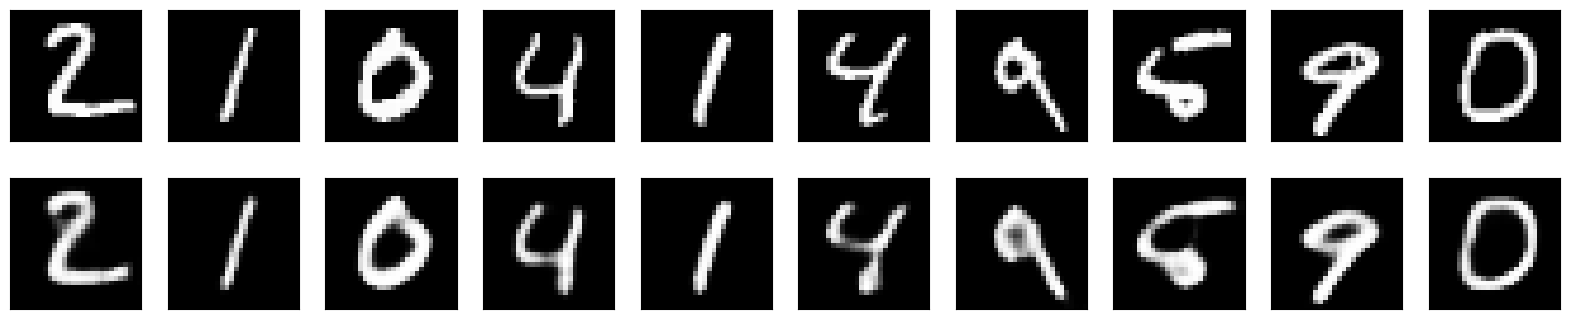

In [17]:
decoded_imgs = autoencoder.predict(x_test_new)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_new[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Exercise-2

In [18]:
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Encoder
input_img = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.3788 - val_loss: 0.1893
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1831 - val_loss: 0.1687
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1668 - val_loss: 0.1578
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1573 - val_loss: 0.1517
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1511 - val_loss: 0.1467
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1472 - val_loss: 0.1433
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1443 - val_loss: 0.1409
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1417 - val_loss: 0.1389
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1401 - val_loss: 0.1372
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1386 - val_loss: 0.1361
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1372 - val_loss: 0.1349
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

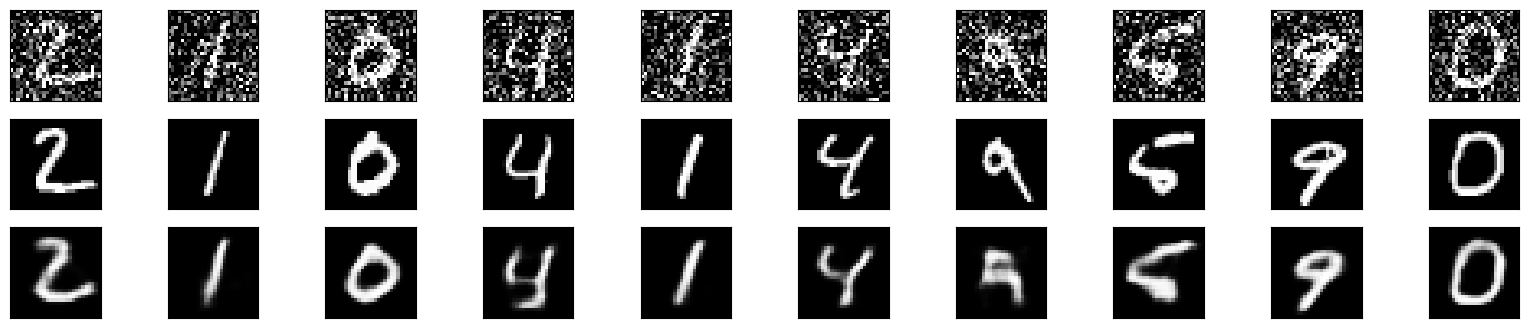

In [19]:
# Adding noise to the images
def add_noise(images):
    noise_factor = 0.5
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)  # Keep pixel values between 0 and 1
    return noisy_images

# Loading the dataset (e.g., MNIST dataset)
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

# Normalize images and reshape them
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train_new = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test_new = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Add noise to the images
x_train_noisy = add_noise(x_train_new)
x_test_noisy = add_noise(x_test_new)

# Train the autoencoder
autoencoder.fit(x_train_noisy, x_train_new,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test_new))

# Evaluate the model
evaluation = autoencoder.evaluate(x_test_noisy, x_test_new, batch_size=128, verbose=1)
print('\nSummary: Loss over the test dataset: %.2f' % (evaluation))

# Generate denoised images
decoded_imgs = autoencoder.predict(x_test_noisy)

# Plot the noisy and denoised images
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display noisy image
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display original (clean) image
    ax = plt.subplot(3, n, i + n)
    plt.imshow(x_test_new[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised (reconstructed) image
    ax = plt.subplot(3, n, i + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
